<a href="https://colab.research.google.com/github/smaliyu/capstone-project/blob/main/Team_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Team 1

## Name of Member:

In [33]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [34]:
# TODO: Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device is: {device}")

Device is: cuda


# Get Data

In [35]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "glioma_meningioma_notumor_pituitary" / "glioma_meningioma_notumor_pituitary"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download glioma, meningioma, notumor, pituitary data
    with open(data_path / "glioma_meningioma_notumor_pituitary.zip", "wb") as f:
        request = requests.get("https://github.com/bbash/ArewaDS-Deep-Learning/raw/main/glioma_meningioma_notumor_pituitary.zip")
        print("Downloading glioma, meningioma, notumor, pituitary data...")
        f.write(request.content)

    # Unzip glioma, meningioma, notumor, pituitary data
    with zipfile.ZipFile(data_path / "glioma_meningioma_notumor_pituitary.zip", "r") as zip_ref:
        print("Unzipping glioma, meningioma, notumor, pituitary data...")
        zip_ref.extractall(image_path)

data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary directory exists.


In [36]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory

  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")



In [37]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary'.
There are 4 directories and 0 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training'.
There are 0 directories and 50 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training/glioma'.
There are 0 directories and 50 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training/meningioma'.
There are 0 directories and 50 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training/notumor'.
There are 0 directories and 50 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training/pituitary'.
There are 4 directories and 0 images in 'data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Testing'.
There are 0 directories and 10 images in 'data/glioma_meningioma_no

In [38]:
# Setup train and testing paths
train_dir = image_path / "Training"
test_dir = image_path /  "Testing"

train_dir, test_dir

(PosixPath('data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training'),
 PosixPath('data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Testing'))

# Data Visalization

Random image path: data/glioma_meningioma_notumor_pituitary/glioma_meningioma_notumor_pituitary/Training/pituitary/Tr-pi_0039.jpg
Image class: pituitary
Image height: 474
Image width: 474


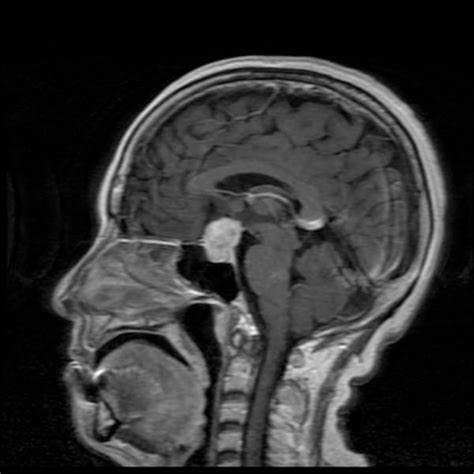

In [39]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

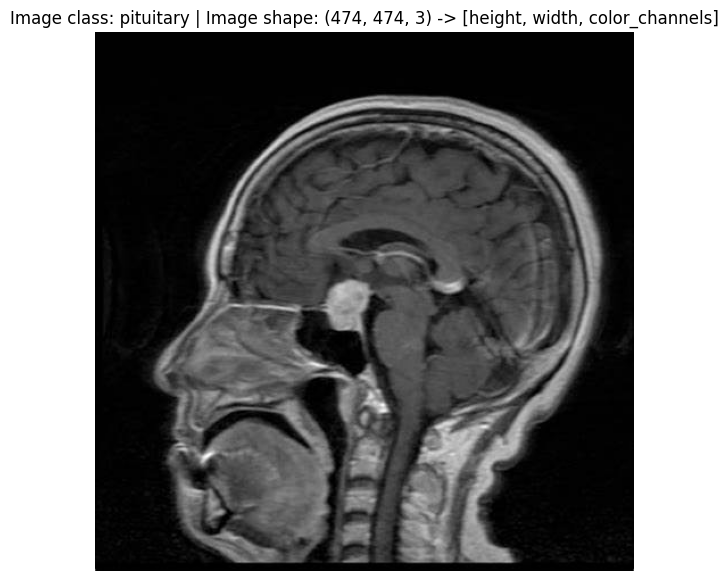

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Data Preparation

In [41]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [42]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7858d60b2500>,
 ['glioma', 'meningioma', 'notumor', 'pituitary'])

## Get and prepare a pretrained model

## implementation of efficientnet_b0

In [43]:
# Setup the model with pretrained weights and send it to the target device

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_0 = efficientnet_b0(weights="DEFAULT")

In [44]:
model_0.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [45]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False


In [46]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

## Train model

In [47]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [48]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.2895 | train_acc: 0.4509 | test_loss: 1.3915 | test_acc: 0.2500
Epoch: 2 | train_loss: 1.0345 | train_acc: 0.6518 | test_loss: 1.2315 | test_acc: 0.4531
Epoch: 3 | train_loss: 0.8243 | train_acc: 0.8393 | test_loss: 1.2689 | test_acc: 0.4062
Epoch: 4 | train_loss: 0.7194 | train_acc: 0.8393 | test_loss: 1.3045 | test_acc: 0.3438
Epoch: 5 | train_loss: 0.6781 | train_acc: 0.8304 | test_loss: 1.3082 | test_acc: 0.4219
[INFO] Total training time: 6.841 seconds


## Make predictions on the entire test dataset with the model

In [49]:
from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model_0.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model_0(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/2 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 3, 0, 2, 2, 0, 2, 3, 0, 2, 2, 2, 0,
        2, 2, 2, 3, 2, 2, 3, 3, 0, 0, 3, 3, 1, 1, 1, 0])

## Make a confusion matrix with the test preds and the truth labels

In [50]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [51]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [52]:

# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

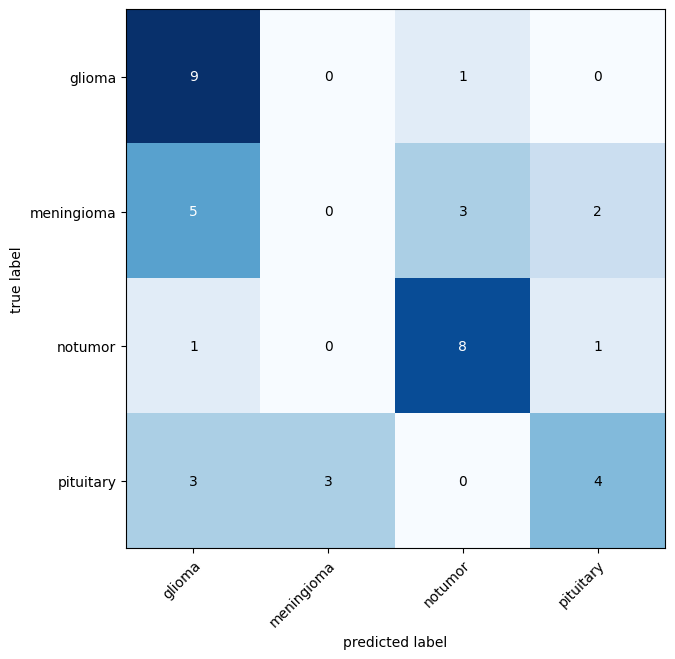

In [53]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
#confmat = ConfusionMatrix(num_classes=len(class_names))
confmat = torchmetrics.ConfusionMatrix(task='multiclass', num_classes=4)
confmat_tensor = confmat(preds=test_preds, target=test_truth)
#confmat_tensor = confmat(preds=test_preds,
 #                        target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)